In [1]:
import os;
os.getcwd()

'/Users/dan/Documents/Finance/Programs/Financial Machine Learning/Backtesting'

In [2]:
import pandas as pd
from tqdm import tqdm
import sys
from datetime import datetime
import pytz
#padas market clandar open_at_time function
import pandas_market_calendars as mcal
# custom imports from this repo
sys.path.append("../Financial Data Structures")
from utils.read_data import read_ticks

In [3]:
cal = mcal.get_calendar("CME_Equity")
sched = cal.schedule(start_date="2023-01-01", end_date="2024-12-31")

In [15]:
ticks = "/Users/dan/Documents/Finance/Historical Data/ES-Futures-Ticks-20230807-20240806.trades.filtered.csv"

skipped_closed = 0
skipped_weekend = 0
skipped_am = 0
skipped_pm = 0

data = {"time": [], "price": [], "volume": [], "symbol": []}
with open(ticks, "r") as f:
    for i, line in enumerate(tqdm(f)):
        if i == 0:
            continue
        line = line.strip().split(",")
        if line[3] != "ESH4":
            continue
        if not cal.open_at_time(sched, line[0]):
            skipped_closed += 1
            continue
        dt = datetime.fromisoformat(line[0])
        if dt.weekday() > 4:
            skipped_weekend += 1
            continue
        if dt.hour < 9 or (dt.hour == 9 and dt.minute < 30):
            skipped_am += 1
            continue
        if dt.hour > 16 or (dt.hour == 16 and dt.minute > 30):
            skipped_pm += 1
            continue
        time = dt.timestamp() 
        data["time"].append(time)
        data["price"].append(float(line[1]))
        data["volume"].append(float(line[2]))
        data["symbol"].append(line[3])

print(f"{skipped_closed=}, {skipped_weekend=}, {skipped_am=}, {skipped_pm=}, {len(data['time'])=}")

82971691it [3:47:30, 6078.10it/s]   

skipped_closed=86649, skipped_weekend=40711, skipped_am=1499093, skipped_pm=9679328, len(data['time'])=9183770


In [ ]:
"""
skipped_closed=86649, skipped_weekend=40711, skipped_am=1499093, skipped_pm=9679328, skipped_sampling=9183769
9183770
"""

In [16]:
df = pd.DataFrame(data)
df.to_csv("ES-Trades-During-Market-Hours.csv", index=False)

In [17]:
len(df)

9183770

In [12]:
df = pd.DataFrame(data)
len(df)

9183770

<Axes: >

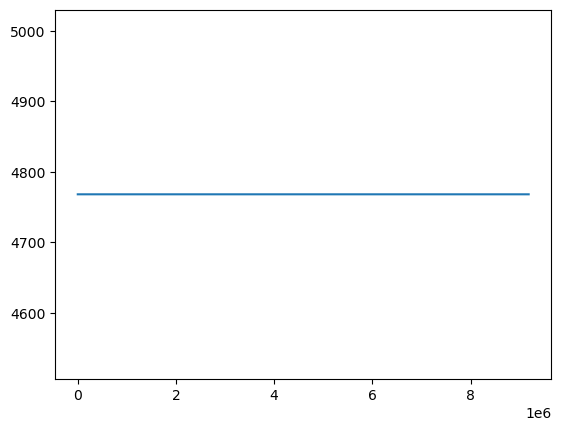

In [14]:
df['price'].plot()

In [ ]:
datetime.fromtimestamp(line[0])

In [ ]:
cal.open_at_time(sched, line[0])

In [ ]:
df = pd.DataFrame(data)

In [ ]:
# the time column contains time in isoformat, convert to datetime in EST

# df["time"] = df["time"].apply(lambda x: datetime.fromtimestamp(x, pytz.timezone("US/Eastern")))
df["time"] = df["time"].progress_apply(lambda x: datetime.fromtimestamp(x, pytz.timezone("US/Eastern")))


In [ ]:
#convert the df time column to a datetime in EST
df

In [ ]:
#now, lets ensure we only trade between 9:30 and 4:30 EST


In [ ]:
# Todo: Apply 1 tick of slippage to each trade

from collections import deque
import numpy as np

window = 600
prices = deque(maxlen=window)
upper_band = 0
lower_band = 0
mu = 0
std = 0
qty = 0
open_price = 0
current_profit = 0
total_profit = 0
commission = 2.25
leverage = 50
trade_cost = commission * 2 / leverage


buys = []
sells = []
holding_periods = []

last_price = data['price'][0]

for i in tqdm(range(len(data['time']))):
    slip_price = last_price
    last_price = data['price'][i]
    prices.append(last_price)
    if len(prices) < window:
        continue

    mu = np.mean(prices)
    std = np.std(prices)

    upper_band = mu + 2 * std
    lower_band = mu - 2 * std

    if qty == 1:
        current_profit = (last_price - open_price) * leverage - trade_cost
    elif qty == -1:
        current_profit = (open_price - last_price) * leverage - trade_cost

    if qty == 0: 
        if last_price < lower_band - trade_cost:
            open_price = last_price
            qty = 1
            mean_side = "under"
            buys.append(i)

        elif last_price > upper_band + trade_cost:
            open_price = last_price
            qty = -1
            mean_side = "over"
            sells.append(i)

    elif qty == 1:
        if last_price >= mu and mean_side == "under":
            open_price = last_price
            qty = 0
            mean_side = "over"
            total_profit += current_profit
            sells.append(i)
            holding_periods.append(sells[-1] - buys[-1])

    elif qty == -1:
        if last_price <= mu and mean_side == "over":
            open_price = last_price
            qty = 0
            mean_side = "under"
            total_profit += current_profit
            buys.append(i)
            holding_periods.append(buys[-1] - sells[-1])


f"{total_profit=}\n{np.mean(holding_periods)=}"




In [ ]:
# plot the prices with markers for buys and sells
import matplotlib.pyplot as plt
plt.plot(data['price'])
plt.scatter(buys, [data['price'][i] for i in buys], color='green', marker='triangle_up')
plt.scatter(sells, [data['price'][i] for i in sells], color='red', marker='triangle_down')
plt.show()